In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import features.config as cf
import features.data_loader as dl
import features.modelling as fm
import features.taxi_cleaning as tcl
import features.taxi_config as tc
import features.taxi_engineering as te

# Load taxi dataset

In [2]:
taxi_data_raw = dl.load_taxi_data()

# Univariat EDA Taxidata

## EDA general

In [3]:
taxi_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


- 1458644 rows
- 11 columns
- object: id, pickup_datetime, dropoff_datetime, store_and_fwd_flag
- int64: vendor_id, passenger_count, trip_duration
- float64: pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
- no missing values/categories

- no NaNs

- id can be used for unique ID
- two unique vendors seems to be all right
- ten unique passengers
- two unique store_and_fwd_flag matches with description

- no duplicated rows

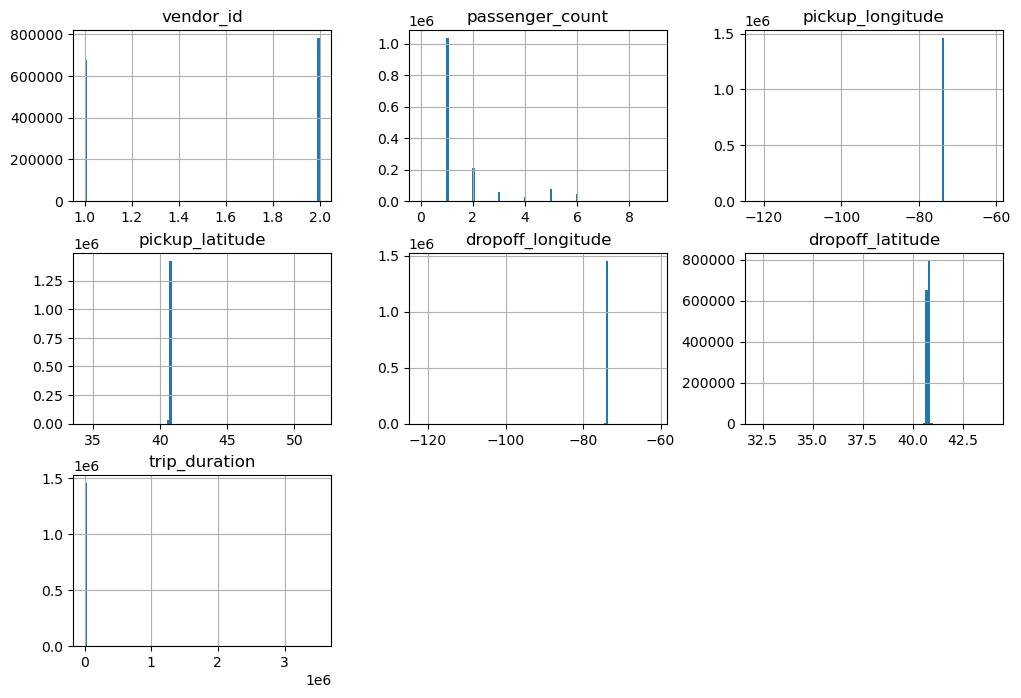

In [4]:
taxi_data_raw.hist(bins=100, figsize=(12, 8))
plt.show()

## Create Test and Train data set

In [5]:
train_set, test_set = fm.split_train_test(taxi_data_raw, cf.TEST_SIZE, cf.RANDOM_STATE)

# Data Cleaning

In [6]:
taxi_data = taxi_data_raw.copy()

## vendor_id

In [7]:
# Vendor ID
taxi_data['vendor_id'].value_counts()

vendor_id
2    780302
1    678342
Name: count, dtype: int64

In [8]:
taxi_data['vendor_id'].isna().sum()

np.int64(0)

- Only two unique values: 1 and 2.
- Frequencies are relatively balanced.
- No missing values or anomalies detected.

##  pickup_datetime & dropoff_datetime

In [9]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], errors='coerce')
taxi_data['dropoff_datetime'] = pd.to_datetime(taxi_data['dropoff_datetime'], errors='coerce')

# Number of missing values
print("Missing pickup_datetime:", taxi_data['pickup_datetime'].isna().sum())
print("Missing dropoff_datetime:", taxi_data['dropoff_datetime'].isna().sum())

Missing pickup_datetime: 0
Missing dropoff_datetime: 0


In [10]:
# Negative or unrealistic trip durations
invalid_times = (taxi_data['dropoff_datetime'] < taxi_data['pickup_datetime'])
print("Trips with negative duration:", invalid_times.sum())

Trips with negative duration: 0


- no negative durations

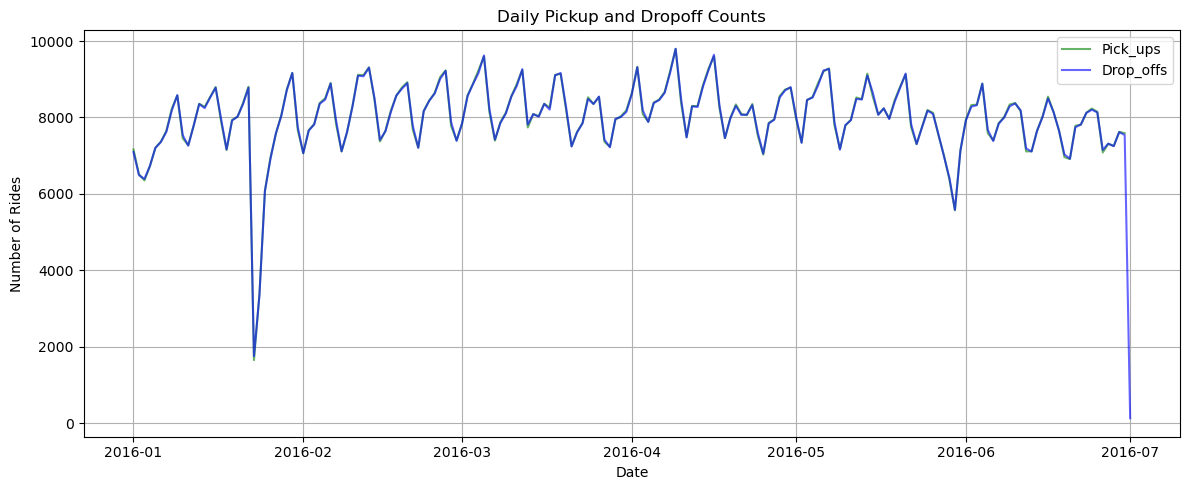

In [11]:
pickup_counts = taxi_data['pickup_datetime'].dt.date.value_counts().sort_index()
dropoff_counts = taxi_data['dropoff_datetime'].dt.date.value_counts().sort_index()

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
pickup_counts.plot(ax=ax, label="Pick_ups", color='green', alpha=0.6)
dropoff_counts.plot(ax=ax, label="Drop_offs", color='blue', alpha=0.6)

ax.set_title("Daily Pickup and Dropoff Counts")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Rides")
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- aligns with expected rush hour effects

##  passenger_count

In [12]:
print(taxi_data['passenger_count'].value_counts().sort_index())

passenger_count
0         60
1    1033540
2     210318
3      59896
4      28404
5      78088
6      48333
7          3
8          1
9          1
Name: count, dtype: int64


- 60 with passenger count 0
- 5 with passenger count > 6

In [13]:
taxi_data['passenger_count_invalid'] = ~taxi_data['passenger_count'].between(1, 6)

<Axes: xlabel='passenger_count'>

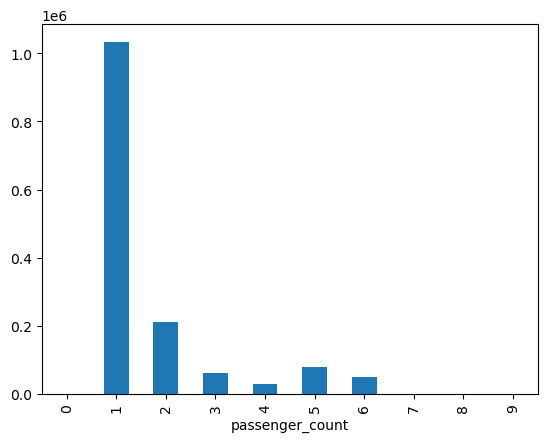

In [14]:
taxi_data['passenger_count'].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='passenger_count'>

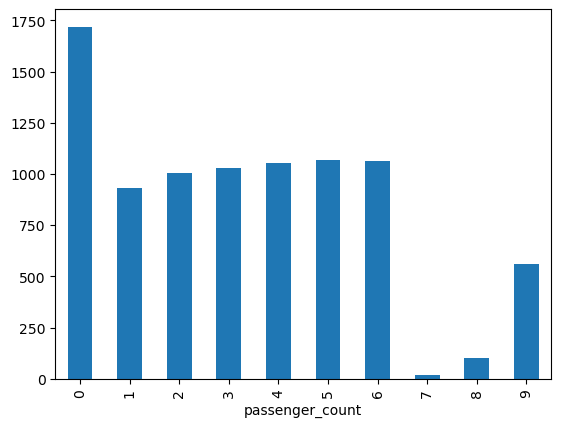

In [15]:
taxi_data.groupby('passenger_count')['trip_duration'].mean().plot(kind='bar')

- Passenger count = 0 has the highest average trip duration, which is not plausible, indicating likely data entry or logging errors

- Passenger count = 1 dominates at all hours
- Group trips (2–4 passengers) are more frequent in the evening and late night

##  pickup_longitude, pickup_latitude & dropoff_longitude, dropoff_latitude

In [16]:
cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
print(taxi_data[cols].describe())

       pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude
count      1.458644e+06     1.458644e+06       1.458644e+06      1.458644e+06
mean      -7.397349e+01     4.075092e+01      -7.397342e+01      4.075180e+01
std        7.090186e-02     3.288119e-02       7.064327e-02      3.589056e-02
min       -1.219333e+02     3.435970e+01      -1.219333e+02      3.218114e+01
25%       -7.399187e+01     4.073735e+01      -7.399133e+01      4.073588e+01
50%       -7.398174e+01     4.075410e+01      -7.397975e+01      4.075452e+01
75%       -7.396733e+01     4.076836e+01      -7.396301e+01      4.076981e+01
max       -6.133553e+01     5.188108e+01      -6.133553e+01      4.392103e+01


In [17]:
taxi_data = tcl.flag_invalid_coords(taxi_data)

- Some trip coordinates lie outside NYC bounds
- Some points lie far outside the visible city bounds — likely due to GPS glitches or data corruption.

### Geographic distribution

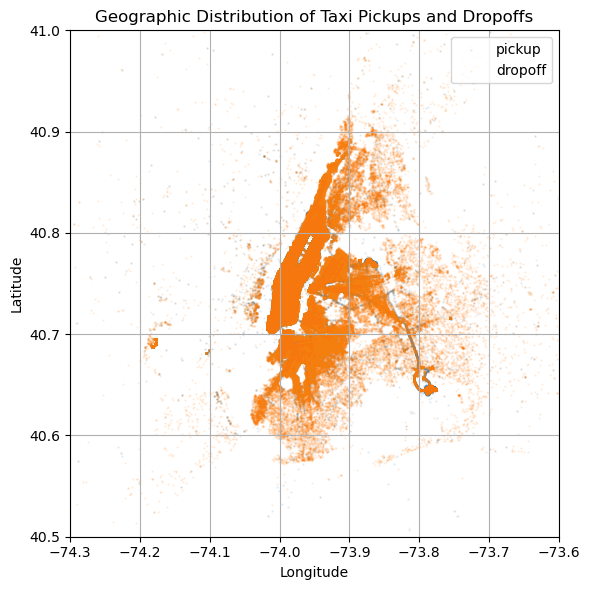

In [18]:
# Scatterplot of pickup and dropoff locations
plt.figure(figsize=(6, 6))
plt.scatter(taxi_data['pickup_longitude'], taxi_data['pickup_latitude'], s=0.5, alpha=0.1,
            label='pickup')
plt.scatter(taxi_data['dropoff_longitude'], taxi_data['dropoff_latitude'], s=0.5, alpha=0.1,
            label='dropoff')
plt.xlim(tc.NYC_LON_MIN, tc.NYC_LON_MAX)
plt.ylim(tc.NYC_LAT_MIN, tc.NYC_LAT_MAX)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper right')
plt.title("Geographic Distribution of Taxi Pickups and Dropoffs")
plt.grid(True)
plt.tight_layout()
plt.show()

- Most pickups and dropoffs are located within the NYC area (Manhattan, Brooklyn, Queens).
- Clear density clusters appear around Midtown and Downtown Manhattan.

In [19]:
taxi_data = tcl.flag_geographic_outliers(taxi_data)

- implausible values

##  store_and_fwd_flag

In [20]:
print(taxi_data['store_and_fwd_flag'].value_counts(dropna=False))

store_and_fwd_flag
N    1450599
Y       8045
Name: count, dtype: int64


In [21]:
taxi_data = tcl.encode_store_and_fwd_flag(taxi_data)

- store_and_fwd_flag = 'Y' is rare and likely not predictive on its own

##  trip_duration

In [22]:
taxi_data['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

In [23]:
taxi_data['trip_duration_outlier'] = ~taxi_data['trip_duration'].between(60, 7200)

<Axes: ylabel='Frequency'>

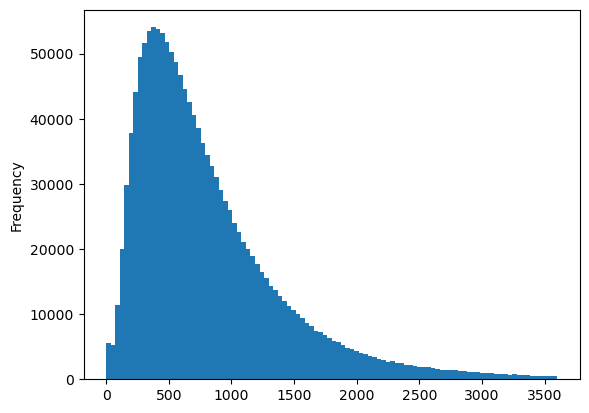

In [24]:
taxi_data['trip_duration'].plot.hist(bins=100, range=(0, 3600))  # bis 1 Stunde

- Several trips have a duration longer than 2 hours, which is highly unlikely for intra-city NYC taxi rides. A few trips are also shorter than 1 minute, which may indicate errors or missing data.

# Feature Engineering

## time feature

In [25]:
taxi_data = te.add_taxi_time_features(taxi_data, 'pickup_datetime')

## trip duration feature

In [26]:
taxi_data = te.add_trip_duration_features(taxi_data)

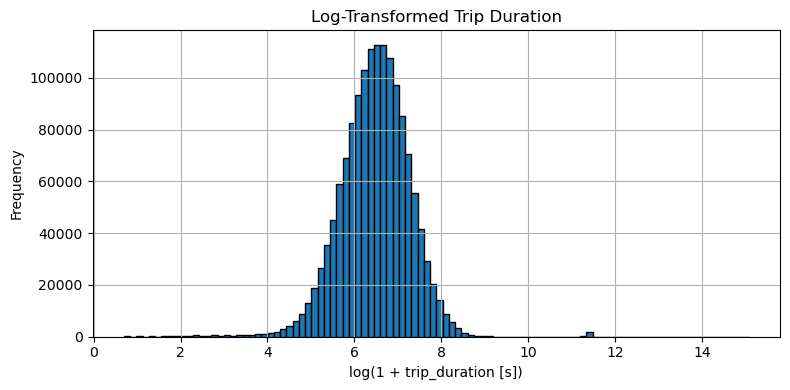

In [27]:
# Log-transformed trip duration
taxi_data['trip_duration_log'] = np.log1p(taxi_data['trip_duration'])

plt.figure(figsize=(8, 4))
plt.hist(taxi_data['trip_duration_log'], bins=100, edgecolor='black')
plt.title("Log-Transformed Trip Duration")
plt.xlabel("log(1 + trip_duration [s])")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

## distance feature (Haversine)

In [28]:
taxi_data = te.add_taxi_distance_features(taxi_data)

<Axes: xlabel='hav_dist_km', ylabel='trip_duration_min'>

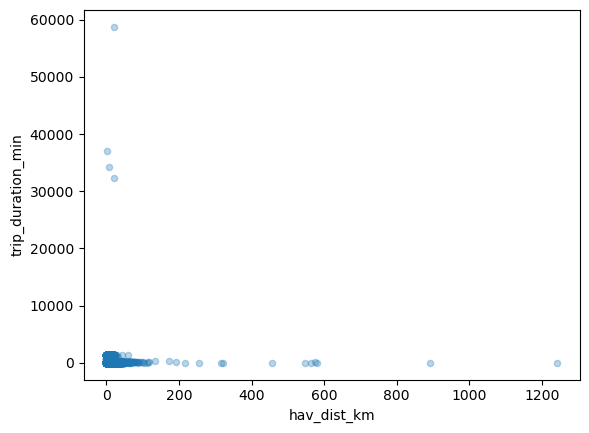

In [29]:
taxi_data.plot.scatter(x='hav_dist_km', y='trip_duration_min', alpha=0.3)

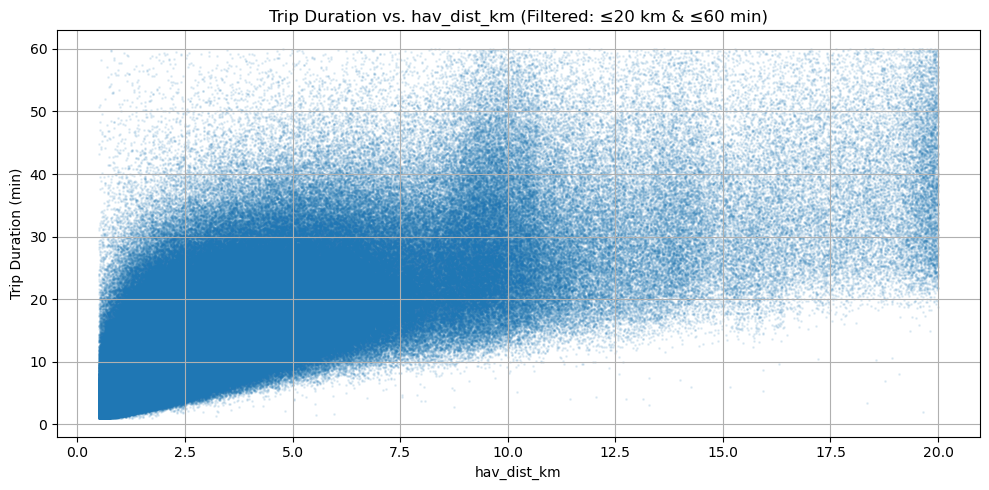

In [30]:
# Filter for clearer visualization
filtered_data = taxi_data[
  (taxi_data['hav_dist_km'] <= 20) &
  (taxi_data['hav_dist_km'] > 0.5) &
  (taxi_data['trip_duration_min'] <= 60) &
  (taxi_data['trip_duration_min'] > 1)
  ]

# Plot
plt.figure(figsize=(10, 5))
plt.scatter(filtered_data['hav_dist_km'], filtered_data['trip_duration_min'], alpha=0.1, s=1)
plt.xlabel("hav_dist_km")
plt.ylabel("Trip Duration (min)")
plt.title("Trip Duration vs. hav_dist_km (Filtered: ≤20 km & ≤60 min)")
plt.grid(True)
plt.tight_layout()
plt.show()

- Long durations at very short distances
- Long distances with short durations

# add distibutions

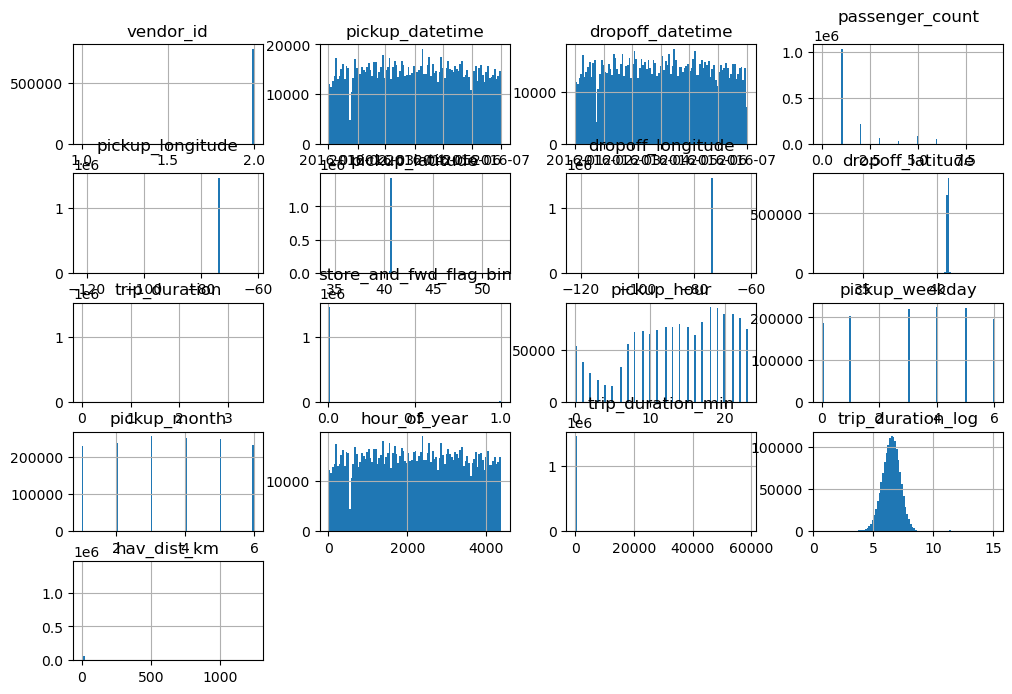

In [31]:
taxi_data.hist(bins=100, figsize=(12, 8))
plt.show()

- For trips under ~2 km, durations vary widely
- Some points still lie far above the trend line

# Save Taxi Data

In [32]:
assert 'hour_of_year' in taxi_data.columns, "hour_of_year fehlt für Merge"
print("Taxi data bereit für Merge mit Wetterdaten.")

Taxi data bereit für Merge mit Wetterdaten.


In [33]:
taxi_data.to_csv(cf.TAXI_DATA_SAVE, index=False)